# SME0823 - Modelos de Regressão e Aprendizado Supervisionado II


---


### Trabalho 2

Selecione um conjunto de dados de uma base de dados pública (Reddit, Kaggle, UCI Machine Learning, etc) relacionado a um problema de classificação.

Proponha um modelo de classificação e avalie sua capacidade preditiva. Variáveis explicativas podem ser selecionadas utilizando critérios como GAIC e IV.

O trabalho pode ser organizado em seções de introdução (descrição dos dados), resultados e discussão.

**Docente**:
Prof.Dr. Mário de Castro


---



**Grupo**:
* Vítor Beneti Martins - n°11877635
* Brenno Hissao Serikawa - n°11296697
* Caio Assumpção Rezzadori - n°11810481


---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Dataframes novos
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Colunas dos dados
    cols = data.columns

    #Calculando WoE e IV para todas as variaveis preditoras
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.cut(data[ivars], bins,  duplicates='drop') # Divisao em subintervalos
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = d['Events'] / d['Events'].sum() # p_j
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = d['Non-Events'] / d['Non-Events'].sum() # q_j
        d = d.loc[(d['Events'] > 0) & (d['Non-Events'] > 0)] # Retirando intervalos sem observcoes das categorias
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)

        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        # Exibindo tabela de WoE
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
def acuracia(X, Y, modelo):
  df = pd.concat([modelo.predict(X), Y], axis = 1).rename({0: 'probabilidade'}, axis = 1)
  df['predicao'] = 0
  df.loc[df.probabilidade > 0.5, 'predicao'] = 1
  acuracia = df[df['diagnosis'] == df['predicao']].shape[0]/df.shape[0]
  return acuracia, df

In [ ]:
dados = pd.read_csv('https://raw.githubusercontent.com/benetche/DatasetRegressaoII/master/data.csv', sep =',')
dados['diagnosis'] = dados['diagnosis'].replace(['M', 'B'], [1, 0])
dados['diagnosis'].value_counts()
dados = dados.dropna(axis = 1)
dados.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
iv, _ = iv_woe(dados, 'diagnosis', bins = 10)
iv = iv.sort_values(by = 'IV', ascending = False)
iv

# Trecho para printar tabela no formato latex
# for i in range(0, iv.shape[0]):
#    print(iv.iloc[i, 0]+  " & " + "$" + str(round(iv.iloc[i, 1], 4)) + "$" + "\\\\")

,Variable,IV
0,concavity_mean,3.719191
0,concavity_worst,3.462885
0,concave points_worst,3.260083
0,radius_worst,3.072599
0,radius_mean,2.933102
0,area_worst,2.810296
0,perimeter_worst,2.552399
0,concave points_mean,2.510874
0,perimeter_mean,2.349947
0,area_mean,2.311034


In [ ]:
list(iv.Variable)

['concavity_mean',
 'concavity_worst',
 'concave points_worst',
 'radius_worst',
 'radius_mean',
 'area_worst',
 'perimeter_worst',
 'concave points_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'area_se',
 'compactness_worst',
 'radius_se',
 'perimeter_se',
 'concave points_se',
 'texture_mean',
 'texture_worst',
 'smoothness_worst',
 'smoothness_mean',
 'symmetry_worst',
 'compactness_se',
 'symmetry_mean',
 'fractal_dimension_worst',
 'concavity_se',
 'fractal_dimension_se',
 'fractal_dimension_mean',
 'symmetry_se',
 'texture_se',
 'smoothness_se',
 'id']

### Modelo 1: Todas as variáveis exceto "id"

In [ ]:

X = dados.drop(['diagnosis', 'id'], axis = 1)

Y = dados.loc[:, 'diagnosis']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

print(res.summary())

# trecho para printar tabela no formato latex
# print(res.summary().as_latex()

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      368
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 13 Nov 2023   Deviance:                   3.6458e-09
Time:                        21:12:46   Pearson chi2:                 1.82e-09
No. Iterations:                    30   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
radius_mean             -1

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparat

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  nan 
Acuracia: 94.15
              precision    recall  f1-score   support

           0      0.962     0.944     0.953       108
           1      0.908     0.937     0.922        63

    accuracy                          0.942       171
   macro avg      0.935     0.940     0.938       171
weighted avg      0.942     0.942     0.942       171



/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


### Estudo de correlações entre as variáveis preditoras

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,-0.31,...,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.01
texture_mean,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,-0.08,...,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.12
perimeter_mean,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,-0.26,...,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.05
area_mean,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,-0.28,...,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.00
smoothness_mean,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.58,...,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.50
compactness_mean,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.57,...,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.69
concavity_mean,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.34,...,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.51
concave points_mean,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.17,...,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.37
symmetry_mean,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,0.48,...,0.19,0.09,0.22,0.18,0.43,0.47,0.43,0.43,0.70,0.44
fractal_dimension_mean,-0.31,-0.08,-0.26,-0.28,0.58,0.57,0.34,0.17,0.48,1.00,...,-0.25,-0.05,-0.21,-0.23,0.50,0.46,0.35,0.18,0.33,0.77


<ipython-input-228-053ab189909c>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))


<Axes: >

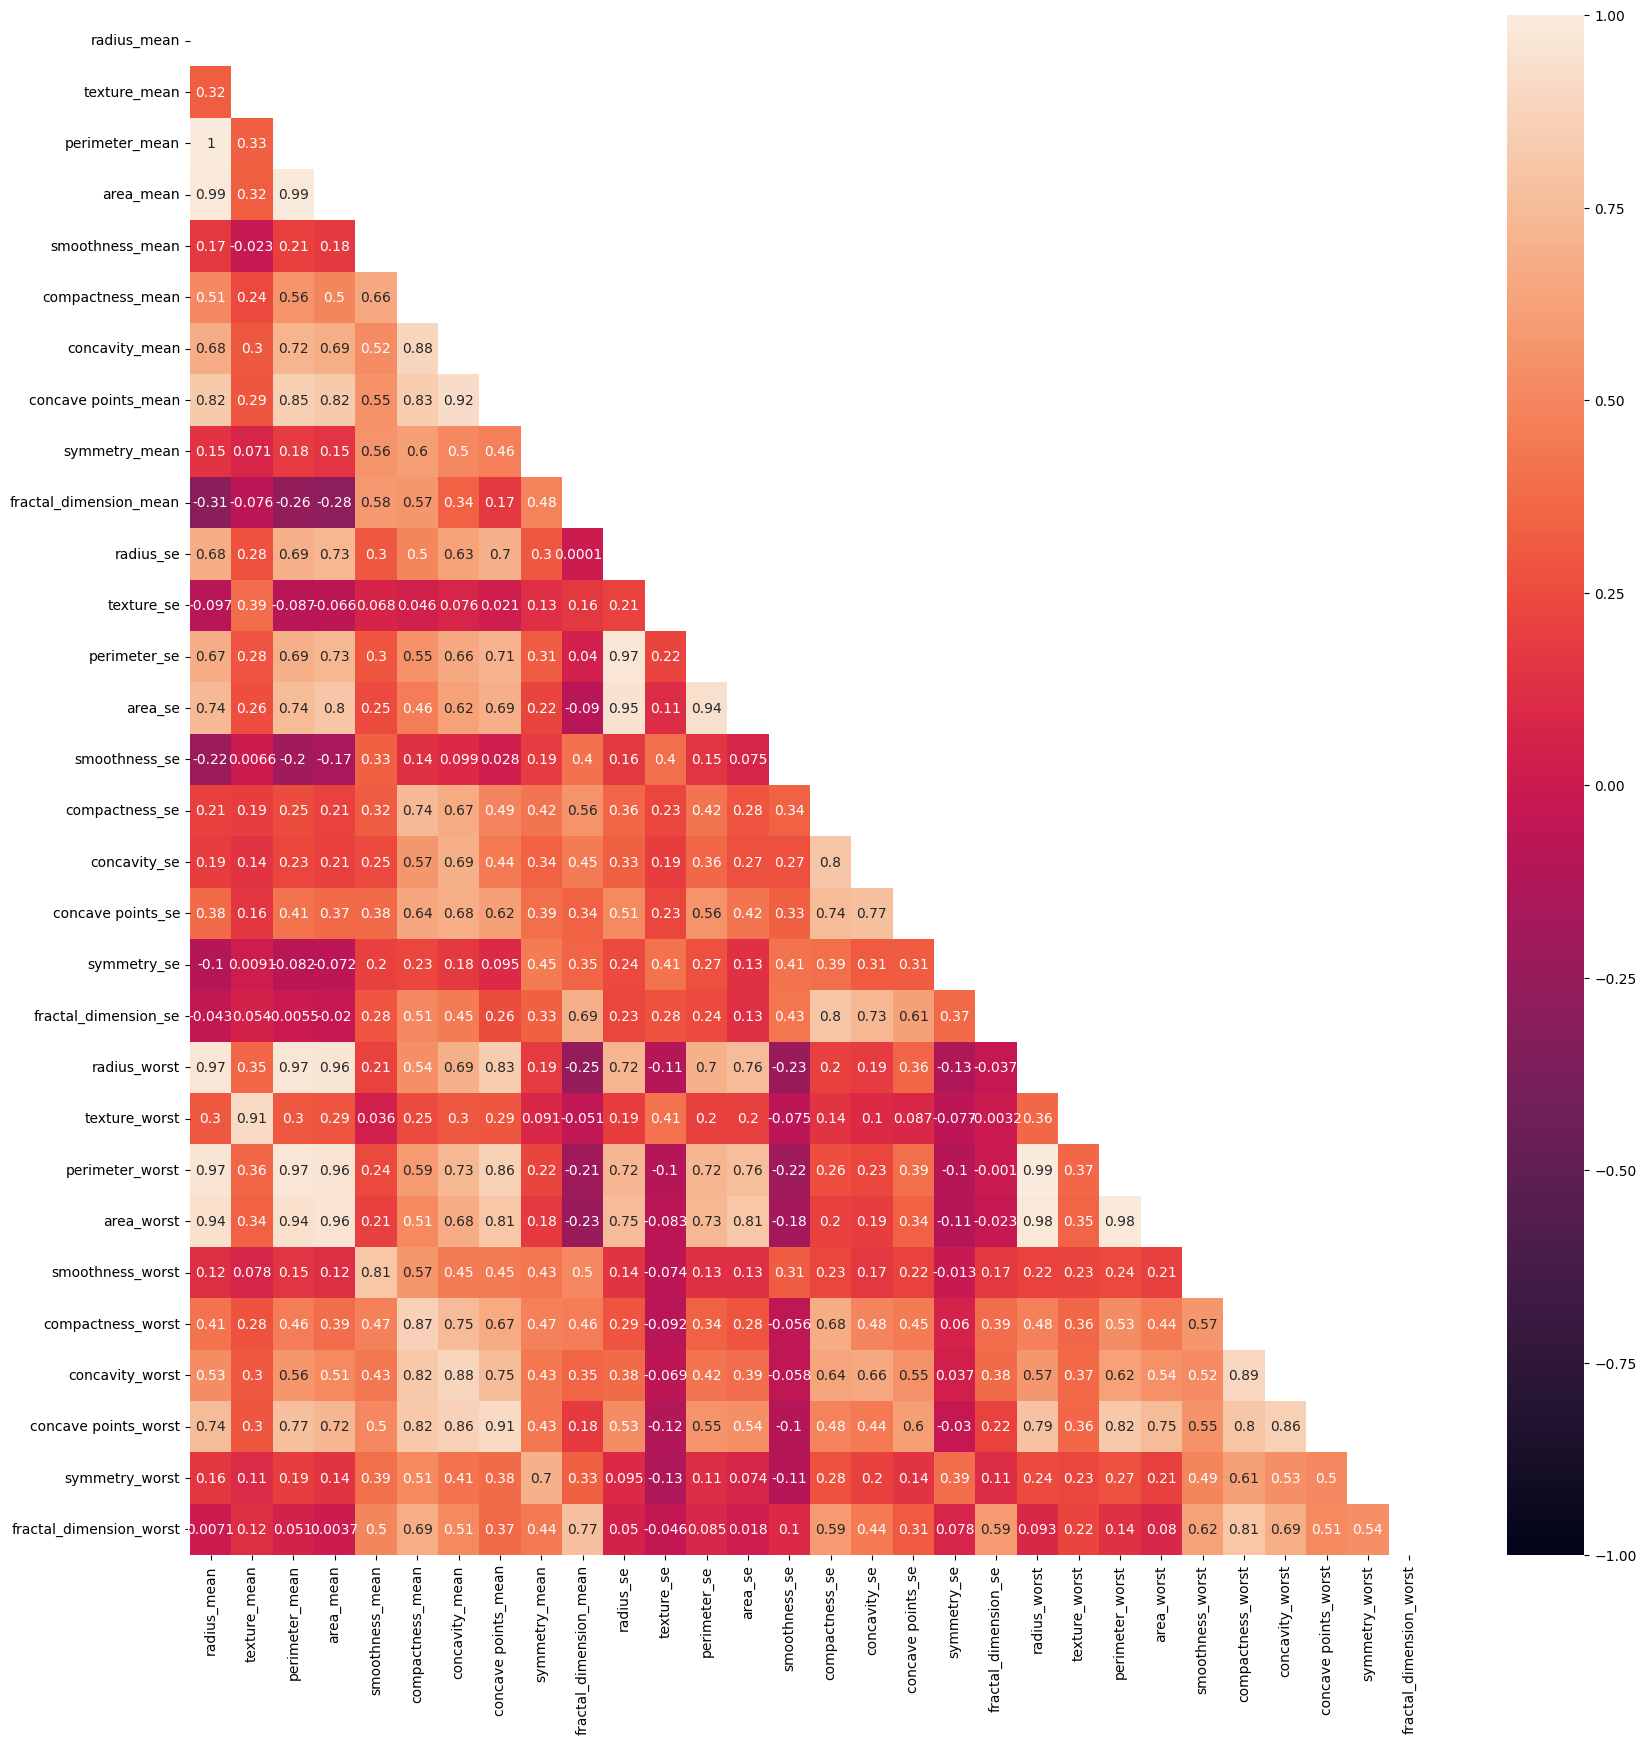

In [ ]:
# Matriz de correlacoes
display(round(X.corr(),2))

# Mapa de calor (heatmap) da matriz de correlacoes
plt.subplots(figsize = (20, 20))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
sns.heatmap(X.corr(), mask = mask, vmin=-1, vmax=1, annot=True)

In [ ]:
# Tabelas de pares de variaveis com mais de 85% de correlacao

aux = np.where(X.corr() > 0.85)
lista_aux = []
variaveis_correlacionadas = pd.DataFrame({'Variavel 1': [], 'Variavel 2': [], 'Correlação': []})
for i, j in zip(aux[0], aux[1]):
  lista_aux += [[i, j]]
  if([j, i] in lista_aux):
    continue
  variaveis_correlacionadas = pd.concat([variaveis_correlacionadas,
                                         pd.DataFrame({'Variavel 1': [X.corr().index[i]], 'Variavel 2':[X.corr().columns[j]], 'Correlação': X.iloc[:, [i, j]].corr().iloc[0, 1]})], axis = 0)

variaveis_correlacionadas = pd.merge(variaveis_correlacionadas, iv.rename({'Variable': 'Variavel 1', 'IV': 'IV 1'}, axis = 1), on = ['Variavel 1'], how = 'left')
variaveis_correlacionadas = pd.merge(variaveis_correlacionadas, iv.rename({'Variable': 'Variavel 2', 'IV': 'IV 2'}, axis = 1), on = ['Variavel 2'], how = 'left')
variaveis_correlacionadas['IV Max'] = [max(x, y) for x, y in zip(variaveis_correlacionadas['IV 1'], variaveis_correlacionadas['IV 2'])]
variaveis_correlacionadas.sort_values(by = ['Correlação', 'IV Max'], ascending= False)

# Trecho para printar tabela no formato latex
# print(round(variaveis_correlacionadas.sort_values(by = ['Correlação', 'IV Max'], ascending= False), 2).to_latex())

,Variavel 1,Variavel 2,Correlação,IV 1,IV 2,IV Max
0,radius_mean,perimeter_mean,0.997855,2.933102,2.349947,2.933102
24,radius_worst,perimeter_worst,0.993708,3.072599,2.552399,3.072599
1,radius_mean,area_mean,0.987357,2.933102,2.311034,2.933102
6,perimeter_mean,area_mean,0.986507,2.349947,2.311034,2.349947
25,radius_worst,area_worst,0.984015,3.072599,2.810296,3.072599
26,perimeter_worst,area_worst,0.977578,2.552399,2.810296,2.810296
21,radius_se,perimeter_se,0.972794,1.586101,1.543173,1.586101
9,perimeter_mean,perimeter_worst,0.970387,2.349947,2.552399,2.552399
2,radius_mean,radius_worst,0.969539,2.933102,3.072599,3.072599
8,perimeter_mean,radius_worst,0.969476,2.349947,3.072599,3.072599


In [ ]:
variaveis_removidas = ['perimeter_mean', 'perimeter_worst', 'radius_mean', 'area_mean', 'area_worst',
                       'perimeter_se', 'radius_se', 'concave points_mean', 'texture_worst', 'compactness_worst',
                       'concavity_worst', 'concave points_worst']

### Modelo 2: Sem variáveis com mais de 85% de correlação

In [ ]:
X = dados.drop(['diagnosis', 'id'] + variaveis_removidas, axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

# trecho para printar tabela no formato latex
# print(res.summary().as_latex())

print(res.summary())

variaveis_significativas = res.pvalues[res.pvalues <= 0.05].index

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      380
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18.815
Date:                Mon, 13 Nov 2023   Deviance:                       37.630
Time:                        21:12:49   Pearson chi2:                     39.6
No. Iterations:                    12   Pseudo R-squ. (CS):             0.7071
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
texture_mean              

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  73.6295105333234 
Acuracia: 94.15
              precision    recall  f1-score   support

           0      0.962     0.944     0.953       108
           1      0.908     0.937     0.922        63

    accuracy                          0.942       171
   macro avg      0.935     0.940     0.938       171
weighted avg      0.942     0.942     0.942       171



### Modelo 3: Modelo 2 com apenas coeficientes significativos

In [ ]:
X = dados.loc[:, variaveis_significativas].drop(['area_se'], axis = 1) # Retirando a outra variavel sem significancia do Modelo 3 (Tabela 6)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

# trecho para printar tabela no formato latex
# print(res.summary().as_latex())

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      394
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74.611
Date:                Mon, 13 Nov 2023   Deviance:                       149.22
Time:                        21:12:49   Pearson chi2:                     359.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6123
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
texture_mean               0

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  157.22224933192874 
Acuracia: 94.74
              precision    recall  f1-score   support

           0      0.971     0.944     0.958       108
           1      0.909     0.952     0.930        63

    accuracy                          0.947       171
   macro avg      0.940     0.948     0.944       171
weighted avg      0.948     0.947     0.948       171



### Modelo 4: Modelo ajustado com apenas as variáveis retiradas

In [ ]:
X = dados.loc[:, variaveis_removidas]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

# print(res.summary().as_latex())

print(res.summary())

variaveis_significativas = res.pvalues[res.pvalues <= 0.05].index

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      386
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.478
Date:                Mon, 13 Nov 2023   Deviance:                       52.956
Time:                        21:12:49   Pearson chi2:                     76.0
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6956
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
perimeter_mean          -0.1632 

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  76.95637410900754 
Acuracia: 96.49
              precision    recall  f1-score   support

           0      0.964     0.981     0.972       108
           1      0.967     0.937     0.952        63

    accuracy                          0.965       171
   macro avg      0.965     0.959     0.962       171
weighted avg      0.965     0.965     0.965       171



### Modelo 5: Modelo 4 com apenas coeficientes significativoss

In [ ]:
X = dados.loc[:, variaveis_significativas]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

print(res.summary().as_latex())

print(res.summary())


\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}        &    diagnosis     & \textbf{  No. Observations:  } &      398    \\
\textbf{Model:}                &       GLM        & \textbf{  Df Residuals:      } &      395    \\
\textbf{Model Family:}         &     Binomial     & \textbf{  Df Model:          } &        2    \\
\textbf{Link Function:}        &      Logit       & \textbf{  Scale:             } &    1.0000   \\
\textbf{Method:}               &       IRLS       & \textbf{  Log-Likelihood:    } &   -160.37   \\
\textbf{Date:}                 & Mon, 13 Nov 2023 & \textbf{  Deviance:          } &    320.75   \\
\textbf{Time:}                 &     21:12:49     & \textbf{  Pearson chi2:      } &     370.    \\
\textbf{No. Iterations:}       &        6         & \textbf{  Pseudo R-squ. (CS):} &   0.4034    \\
\textbf{Covariance Type:}      &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
   

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  326.74708067609265 
Acuracia: 88.3
              precision    recall  f1-score   support

           0      0.907     0.907     0.907       108
           1      0.841     0.841     0.841        63

    accuracy                          0.883       171
   macro avg      0.874     0.874     0.874       171
weighted avg      0.883     0.883     0.883       171



### Modelo 6: Modelo com apenas 1 variável preditora

In [ ]:
X = dados.loc[:, ['concavity_mean']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

# print(res.summary().as_latex())

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      397
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -263.15
Date:                Mon, 13 Nov 2023   Deviance:                       526.29
Time:                        21:39:11   Pearson chi2:                     395.
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001387
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
concavity_mean     4.6065      0.968      4.

In [ ]:
print('GAIC: ', res.aic, '\nAcuracia:', round(acuracia(X_test, Y_test, res)[0]*100, 2))

print(classification_report(Y_test, acuracia(X_test, Y_test, res)[1].predicao, digits=3)) # Tabela de resultados (precisao, recall, f1, support)

GAIC:  528.2930670964753 
Acuracia: 39.18
              precision    recall  f1-score   support

           0      1.000     0.037     0.071       108
           1      0.377     1.000     0.548        63

    accuracy                          0.392       171
   macro avg      0.689     0.519     0.310       171
weighted avg      0.771     0.392     0.247       171



In [ ]:
pd.concat([X['concavity_mean'], res.predict(X)], axis = 1).sort_values(by = 'concavity_mean')

In [ ]:
X = dados.loc[:, ['concavity_mean']]

Y = dados['diagnosis']
res = GLM(
    Y,
    X,
    family=families.Binomial(),
).fit()
acuracia(X, res)
plt.scatter(X, Y)

plt.plot(np.linspace(X.min(), X.max()), res.predict(np.linspace(X.min() - 1, X.max() + 1)))

In [ ]:
teste = ['radius_mean', 'texture_mean',  'smoothness_mean', 'compactness_mean',
         'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
         'smoothness_se', 'compactness_se', 'symmetry_se', 'fractal_dimension_se']

X = dados.loc[:, teste]

Y = dados['diagnosis']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 23)

res = GLM(
    Y_train,
    X_train,
    family=families.Binomial(),
).fit()

# print(res.summary().as_latex())

print(res.summary())